# RULES FOR WRITING SOFTWARE WITH EXAMPLES

This notebook describes and motivates the rules for writing software.

In [1]:
import numpy as np
import pandas as pd

# Handling dependencies
You must ensure that any packages (dependencies) required for your code to run are installed.

Installing Tellurium
``!pip install -q tellurium``

Now we can import tellurium
``import tellurium as te``

In [2]:
# First code cell in a notebook contains all installs
!pip install -q tellurium
!pip install -q simplesbml
!pip install -q sympy

In [3]:
# Second code cell has all imports
import pandas as pd     # DataFrames and Series
import numpy as np      # Numerical methods
import simplesbml       # Access to reaction network metadata
import sympy            # Symbolic algebra
import tellurium as te  # Simulations

# Use functions instead of scripts
Whenever possible, use functions instead of scripts. 
This is because functions facilitate reuse, and functions are testable. 
Never use copy and paste for reuse

In [4]:
import numpy as np
# Script that tests if a number is prime
number = 12
is_prime = True
for factor in range(2, int(np.sqrt(number))):
    if number % factor == 0:
        is_prime = False
if is_prime:
    answer = "yes"
else:
    answer = "no"
print("Is %d prime? %s" % (number, answer))

Is 12 prime? no


## Why aren't scripts enough?

Testing the script is cumbersome -- must try and evaluate many values.

Difficult to reuse script. How embed this in code that prints the first $N$ prime numbers?

## Making a script into a function

Steps
1. Determine the interface - inputs and outputs
1. Write the ``def`` statement
1. Document the function
1. Copy the script into the function body.
1. Add the return statement.
1. Delete unneeded code (e.g., ``print``)

The above script can be made into the function ``checkPrime``.

In [5]:
def checkPrime(number):
    """
    Determines if the number is a prime.
    
    Parameters
    ----------
    number: int
    
    Returns
    -------
    bool
    """
    is_prime = True
    for factor in range(2, int(np.sqrt(number)) + 1):
        if number % factor == 0:
            is_prime = False
    return is_prime

In [6]:
answers = ["Yes", "No"]
number = 24
print("Is %d prime? %s" % (number, checkPrime(number)))

Is 24 prime? False


Now we can use ``checkPrime`` as a building block to create other functions.

In [7]:
# Find the first N primes
def findPrimes(count):
    """
    Finds the count of primes indicated.
    
    Parameters
    ----------
    count: int
    
    Returns
    -------
    list-int
    """
    results = []
    number = 1
    while True:
        if len(results) >= count:
            break
        number += 1
        if checkPrime(number):
            results.append(number)
    return results

In [8]:
findPrimes(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

## Exercise

Write a function that finds all primes less than a given number and calls ``findPrimes``.

# Names of variables and functions

Use meaningful names for functions are variables. Function names should be verbs. 
For example, a function that calculates a fast Fourier transform might be named calcFFT.
A bad name for this function would be the single letter f.

Why did we name the function ``checkPrimes`` instead of ``f``?

In [9]:
# Re-write this function according the the rules for variable and function names.
# Show that you get the same result as the original code.
def p(n):
    r = 1
    for i in range(len(n)):
        r *= n[i]
    return r

In [10]:
p([4, 3, 2])

24

# Use named constants
Constants used in the notebook should have a name in all capital letters. For example, use ``PI``, not ``pi``.
(By definition, a constant is a variable that is assigned a value only once.)
Named constants should also be used for dataframes.
For example, instead of ``df["mean"]`` use ``df[MEAN]``, where ``MEAN = "mean"`` appears elsewhere.

In [11]:
MODEL = """
J0: $X -> A; k1
J1: A -> B; k2*A
X =10
A = 0
B = 0
k1 = 1
k2 =1
"""

In [12]:
# Get data from running the simulation
rr = te.loada(MODEL)
data = rr.simulate(0, 5, 100, ["time", "[A]", "[B]", "J1"])
data_df = pd.DataFrame(data, columns = data.colnames)
data_df.head(2)

,time,[A],[B],J1
0,0.000000,0.000000,0.000000,0.000000
1,0.050505,0.049251,0.001254,0.049251


In [13]:
# See that mass action kinetics are present
checks_ser = data_df["J1"] == data_df["[A]"]
checks_ser.head(3)

0    True
1    True
2    True
dtype: bool

In [14]:
# Check the mass action rate law for J1
assert(sum(data_df["J1"] == data_df["[A]"]) == len(data_df))

# Document your functions

After the function definition, you should have comment lines that specify:
* What the function does
* The data types of each input and output (including names of columns if an input is a dataframe) 


# Functions must have tests

You must have at least one test for each function that shows that the major code paths work correctly.
In a Jupyter notebook, the tests should follow the function definition in the code cell in which the function is defined.
The test will use the python assert statement to evaluate a boolean condition that constitutes the test.
For python modules, you will create a separate test file that uses the python unittest framework.

# Example - Symbolic Linearization of the Reaction Network

The reaction network is approximated by the linearization $\dot{{\bf x}} = {\bf A} {\bf x}$,
where ${\bf x}$ is the column vector of species concentrations and ${\bf A} = {\bf N} {\bf J}$,
where ${\bf N}$ is the stoichiometry matrix and ${\bf J}$ is the Jacobian of the reaction rate vector.

Tellurium provides access to the numerical ${\bf A}$ matrix evaluated at a specific time in the simulation (by default, the end of the simulation). From this, we can make inferences about the nature of fixed points.
However, this applies only to the parameter values and initial conditions used in that simulation.
If we want to make broad statements about a model, we'd like to reason from the symbolic Jacobian, the Jacobian in terms of the
parameters and species in the model.

## Why Symbolic Linearization

Consider the model below.
We want to determine if there are *any* values of the parameters for which the model becomes unstable or oscillates.

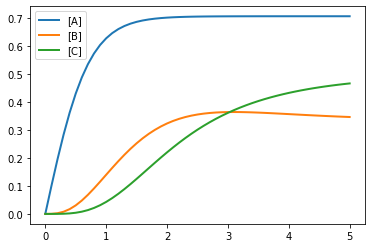

In [15]:
MODEL = """
$X -> A; k1
2A -> B; k2*A^2
B -> C; k3*B
B + 2C ->; k4*B*C
X = 1
A = 0;
B = 0
C = 0
k1 = 1;
k2 = 1;
k3 = 1;
k4 = 1
"""
rr = te.loada(MODEL)
rr.simulate()
rr.plot()

Roadrunner can calculate the ${\bf A}$ matrix numerically.

In [16]:
AMat = rr.getReducedJacobian()
AMat

            A,         B,         C
A [[ -2.82842,         0,         0],
B  [  1.41421,  -1.46676, -0.346645],
C  [        0, 0.0664758, -0.693291]]

The eigenvalues lie on the diagonal of the matrix; they are negative and real. So in this case, we have a non-oscillating, stable system.
But is this true for all feasible values of the parameters (which must always be positive)?

## Calculating Symboic Linearizations

To obtain the symbolic ${\bf A}$ matrix
requires two additional python packages.
* ``simplesbml`` provides access to the symbols in the model, including the rates laws.
* ``sympy`` is a symbolic algebra package for python

In [17]:
# Create a SimpleSBML representation of the roadrunner model
simple_model = simplesbml.loadSBMLStr(rr.getSBML())

In [19]:
# The following creates sympy symbols for the float species and parameters in the model
species = simple_model.getListOfFloatingSpecies()  # list of the names of floating species as strings
parameters = simple_model.getListOfParameterIds()  # list of the names of the parameters
symbols = list(species)
symbols.extend(parameters)                  # List of all the symbols we want to create
stmt = "%s = sympy.symbols(%s)" % (", ".join(symbols), str(symbols))  # Python statement to create the symbols
exec(stmt, globals(), locals())                                  # Execute the python statement

In [20]:
# Construct a list of the rate laws
rate_laws = []
for id in simple_model.getListOfReactionIds():
    rate_laws.append(simple_model.getRateLaw(id))
#
rate_laws            

['k1', 'k2 * pow(A, 2)', 'k3 * B', 'k4 * B * C']

Elements of the rate laws are strings.
To make them into expressions, we use the python ``eval`` function.

In [21]:
# Construct the Jacobian of the rate vector using symbolic algebra
vector = sympy.Matrix([eval(l) for l in rate_laws])
jacobian = vector.jacobian(species)
jacobian

Matrix([
[     0,    0,    0],
[2*A*k2,    0,    0],
[     0,   k3,    0],
[     0, C*k4, B*k4]])

Next, we create a sympy version of the stoichiometry matrix.

In [22]:
stoichiometryMat = sympy.Matrix(rr.getFullStoichiometryMatrix())
stoichiometryMat

Matrix([
[1.0, -2.0,  0.0,  0.0],
[0.0,  1.0, -1.0, -1.0],
[0.0,  0.0,  1.0, -2.0]])

We get the ${\bf A}$ matrix by multiplication.

In [23]:
stoichiometryMat * jacobian

Matrix([
[-4.0*A*k2,                  0,         0],
[ 2.0*A*k2, -1.0*C*k4 - 1.0*k3, -1.0*B*k4],
[        0, -2.0*C*k4 + 1.0*k3, -2.0*B*k4]])

Analyzing this matrix, we see that the eigenvalues are the elements of the diagonal,
and all of these elements are real and negative (since species concentrations and parameters are non-negative).
Thus, this network will *always* converge and will *never* oscillate.

## Converting the code fragments into reproducible, reusable software

Requirements
1. Define the interface to the user
1. Create functional components
1. Write tests for the components